<a href="https://colab.research.google.com/github/atmark-techno/armadillo-iot-g4_model_zoo/blob/main/GoogleColabNotebooks/HandEstimation_OperationCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## モデルのダウンロード

[PINTO0309](https://github.com/PINTO0309)様が量子化したモデルがArmadillo-IoT ゲートウェイ G4上でも使用できますので、そちらを使用します。

In [1]:
%%bash
mkdir tmp
cd tmp
wget https://raw.githubusercontent.com/PINTO0309/PINTO_model_zoo/main/033_Hand_Detection_and_Tracking/03_integer_quantization/download_new.sh
bash download_new.sh
cp hand_landmark_new_256x256_integer_quant.tflite ../hand.tflite

wget https://raw.githubusercontent.com/PINTO0309/PINTO_model_zoo/main/033_Hand_Detection_and_Tracking/03_integer_quantization/download.sh
bash download.sh
cp palm_detection_builtin_256_integer_quant.tflite ../palm.tflite

cd ..
rm -rf tmp

hand_landmark_new_256x256_integer_quant.tflite
Download finished.
palm_detection_builtin_256_integer_quant.tflite
hand_landmark_256_integer_quant.tflite
hand_landmark_3d_256_integer_quant.tflite
Download finished.


--2022-08-25 04:05:27--  https://raw.githubusercontent.com/PINTO0309/PINTO_model_zoo/main/033_Hand_Detection_and_Tracking/03_integer_quantization/download_new.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366 [text/plain]
Saving to: ‘download_new.sh’

     0K                                                       100% 19.8M=0s

2022-08-25 04:05:28 (19.8 MB/s) - ‘download_new.sh’ saved [366/366]

download_new.sh: line 4: warning: command substitution: ignored null byte in input
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1977k  100 1977k    0     0  1310k      0

## テスト画像のダウンロード

In [2]:
# テスト画像をtest.jpgという名前で保存します。
%%bash
wget "https://unsplash.com/photos/XjeaxxcT0ug/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYxMjM0NzMw&force=true&w=1920" -O test.jpg

--2022-08-25 04:06:03--  https://unsplash.com/photos/XjeaxxcT0ug/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYxMjM0NzMw&force=true&w=1920
Resolving unsplash.com (unsplash.com)... 151.101.1.181, 151.101.193.181, 151.101.129.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.1.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1609043238954-c069d4e5a0e4?ixlib=rb-1.2.1&dl=ej-agumbay-XjeaxxcT0ug-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb [following]
--2022-08-25 04:06:03--  https://images.unsplash.com/photo-1609043238954-c069d4e5a0e4?ixlib=rb-1.2.1&dl=ej-agumbay-XjeaxxcT0ug-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb
Resolving images.unsplash.com (images.unsplash.com)... 146.75.78.208, 2a04:4e42:84::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.78.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380593 (372K) [image/jpeg]
Saving to: ‘tes

## 必要なファイルのダウンロード

In [3]:
# 推論モデルが出力するデータを整形する際に使用するライブラリを取得します。
%%bash
git clone https://github.com/geaxgx/depthai_hand_tracker.git
cp depthai_hand_tracker/mediapipe_utils.py ./

Cloning into 'depthai_hand_tracker'...


# テストコード

## ライブラリのインポート

In [4]:
from tensorflow.lite.python.interpreter import Interpreter # Armadillo-IoT ゲートウェイ G4 実機上では、"from tflite_runtime import Interpreter" としてインポートしてください。
import cv2
import numpy as np
import mediapipe_utils as mpu
from google.colab.patches import cv2_imshow # Google colab上でcv2画像を表示するために必要なライブラリ

## 画像内の手の位置の検出

### 手の位置検出用 interpreter の準備

In [5]:
interpreter_palm = Interpreter('palm.tflite')
interpreter_palm.allocate_tensors()
input_details_palm = interpreter_palm.get_input_details()
output_details_palm = interpreter_palm.get_output_details()
print(input_details_palm)
print(output_details_palm)

_, i_height_palm, i_width_palm, _ = input_details_palm[0]['shape']

[{'name': 'input', 'index': 308, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'classificators', 'index': 309, 'shape': array([   1, 2944,    1], dtype=int32), 'shape_signature': array([   1, 2944,    1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'regressors', 'index': 310, 'shape': array([   1, 2944,   18], dtype=int32), 'shape_signature': array([   1, 2944,   18], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 

### テスト画像を読み込み、モデルに入力する形に整形する

In [6]:
img = cv2.imread('test.jpg')
src_height, src_width, _ = img.shape
input_image = cv2.resize(img, (i_width_palm, i_height_palm))
input_image = input_image / 255
input_image = np.expand_dims(input_image, 0).astype(input_details_palm[0]['dtype'])

### 推論実行

In [7]:
interpreter_palm.set_tensor(input_details_palm[0]['index'], input_image)
interpreter_palm.invoke()

### 推論結果を抽出

In [8]:
scores = interpreter_palm.get_tensor(output_details_palm[0]['index']).squeeze()
bboxes = interpreter_palm.get_tensor(output_details_palm[1]['index']).squeeze()

### 推論結果の後処理

In [22]:
MAX_HANDS = 2 # 検出する手の最大数を指定します。最大で10個検出できます。
HAND_SCORE_THRESH = 0.90 # ここで指定した値以上の確度で手と判断した物のみ出力します。

In [23]:
anchors = mpu.generate_handtracker_anchors(i_height_palm, i_height_palm)[:output_details_palm[0]['shape'][1]]
hands = mpu.decode_bboxes(HAND_SCORE_THRESH, scores, bboxes, anchors, scale=i_height_palm, best_only=False)
mpu.detections_to_rect(hands)
mpu.rect_transformation(hands, src_width, src_height)
hands = mpu.non_max_suppression(hands, 0.3)[:MAX_HANDS]

### 元の画像と重ね合わせて描画

In [24]:
f = img.copy()
world_key_point = []
for hand in hands:
    f = cv2.polylines(
        img=f,
        pts=[np.array(hand.rect_points)],
        isClosed=True,
        color=(0, 255, 0),
        thickness=3,
        lineType=cv2.LINE_4
    )

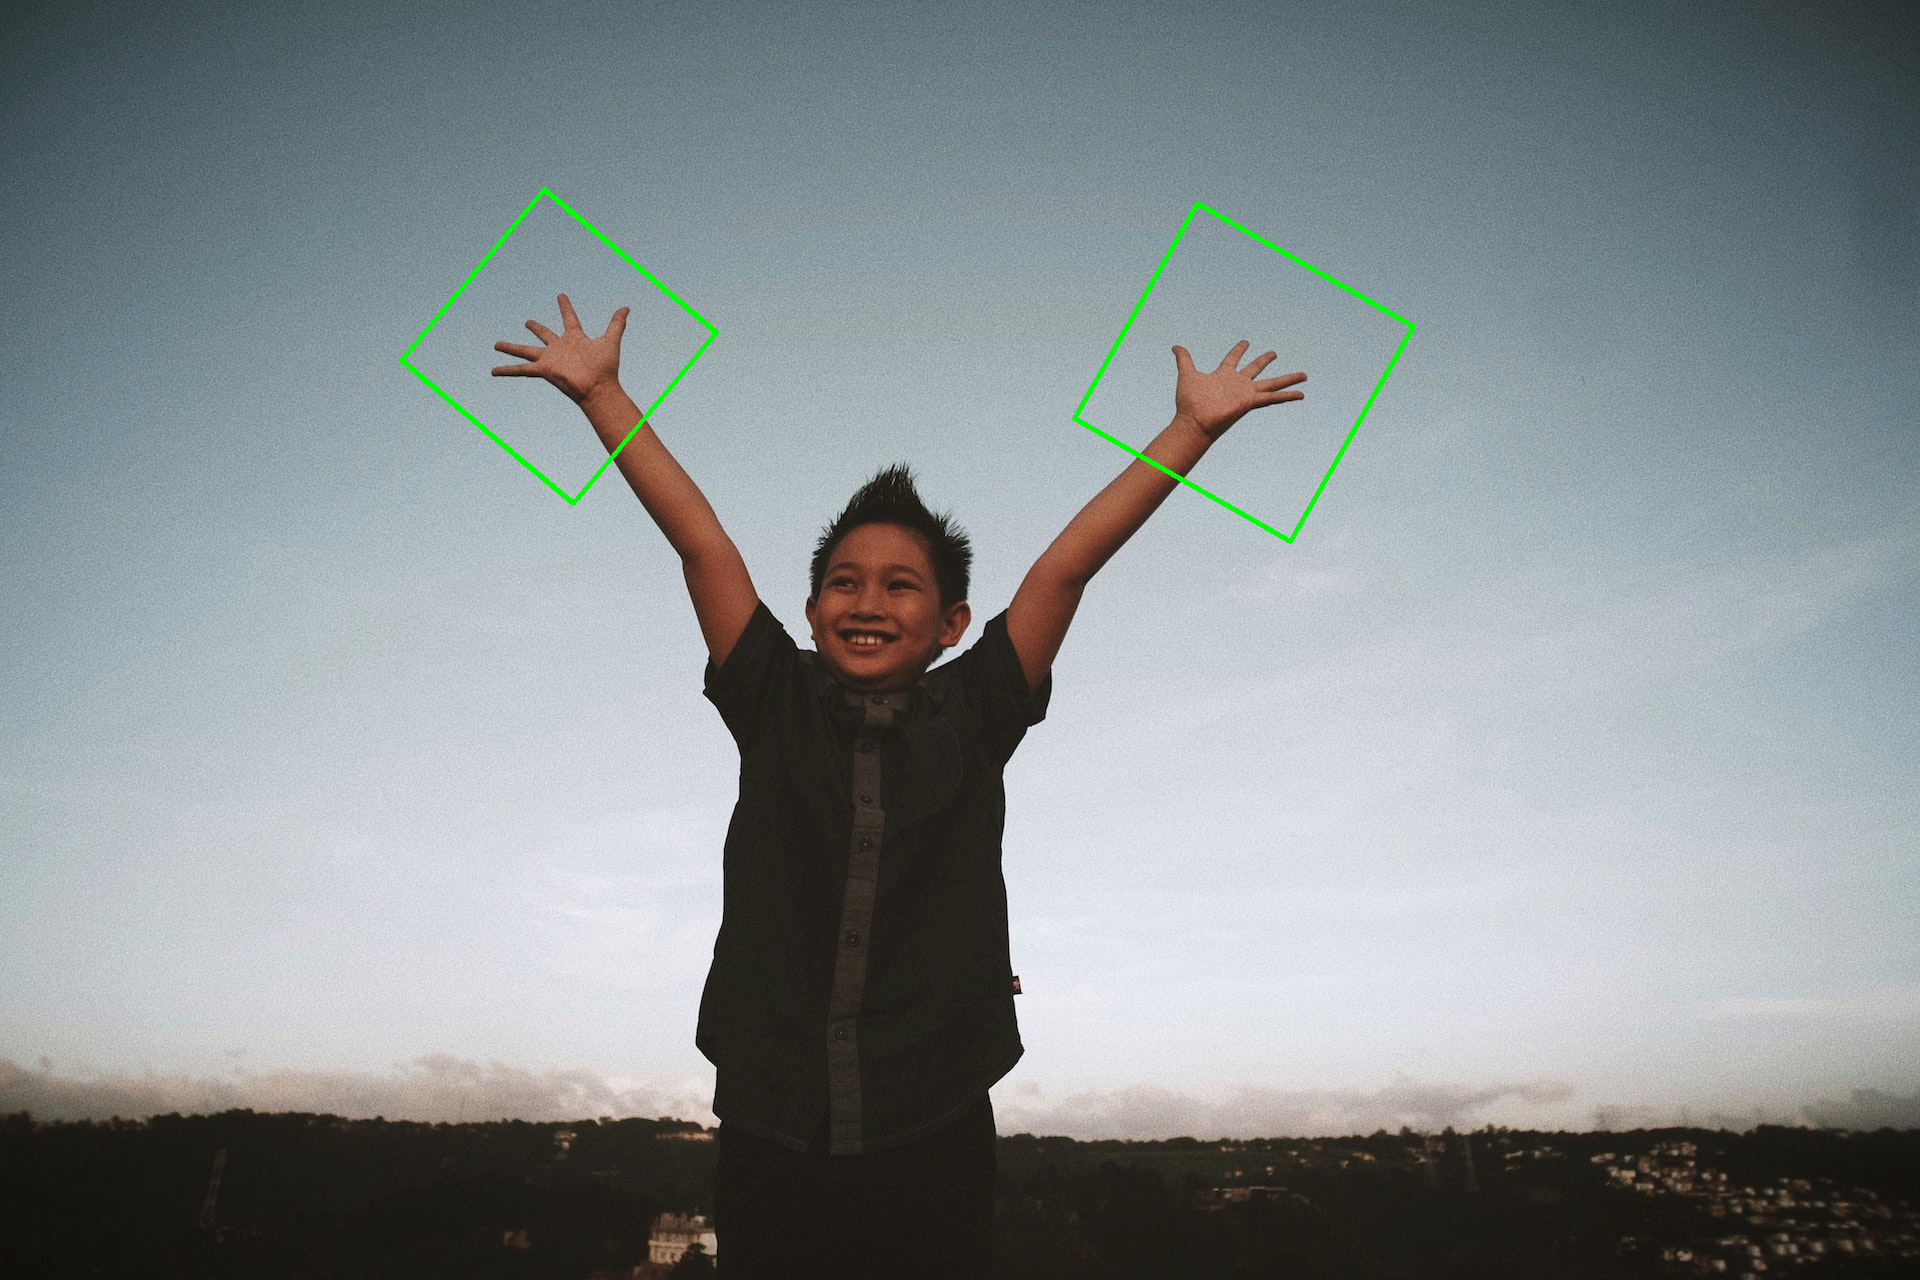

In [25]:
cv2_imshow(f)

## 検出した手の骨格検知

ここまでの手順で検出した手の領域を切り取り、切り取った領域に対して骨格検知を行ないます。

### 骨格検知用 interpreter の準備

In [26]:
interpreter_hand = Interpreter('hand.tflite')
interpreter_hand.allocate_tensors()
input_details_hand = interpreter_hand.get_input_details()
output_details_hand = interpreter_hand.get_output_details()
print(input_details_hand)
print(output_details_hand)

_, i_height_hand, i_width_hand, _ = input_details_hand[0]['shape']

[{'name': 'input', 'index': 308, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([ -1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 309, 'shape': array([1, 1, 1, 1], dtype=int32), 'shape_signature': array([-1,  1,  1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'Identity_1', 'index': 310, 'shape': array([1, 1, 1, 1], dtype=int32), 'shape_signature': array([-1,  1,  1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([

### 関数定義

In [27]:
# frameから指定した領域(rect_points)で切り抜いて、切り抜いた画像を返す関数
# 入力：オリジナル画像、切り抜く領域
# 出力：切り抜かれた画像
def crop(frame, rect_points):
    h, w, _ = frame.shape
    left = w
    right = 0
    top = h
    bottom = 0

    for p in rect_points:
        left = max(0, min(p[0], left))
        right = min(w, max(p[0], right))
        top = max(0, min(p[1], top))
        bottom = min(h, max(p[1], bottom))
    return (frame[top:bottom, left:right], (left, top))

### 画像を切り抜く

In [28]:
frame = img.copy()
cropped_hands = []
for hand in hands:
    d = {}

    # 後でも使用するのでオリジナル画像における手の領域の中心座標を保存しておきます。
    hand_center = (int(hand.rect_x_center_a), int(hand.rect_y_center_a))
    d['hand_center'] = hand_center

    # 今回使用するモデルは、手の向きが正位置(中指が上、手首が下)でなければ精度が出にくいので、画像を回転させます。
    # まず、回転行列を算出します。
    trans = cv2.getRotationMatrix2D(
        center=hand_center,
        angle=np.rad2deg(hand.rotation),
        scale=1
    )
    # 後で回転した画像を元に戻すため、逆回転用の回転行列を算出して保存しておきます。
    trans_inv = cv2.getRotationMatrix2D(
        center=hand_center,
        angle=np.rad2deg(-hand.rotation),
        scale=1
    )
    d['trans_inv'] = trans_inv

    # 求めた回転行列とアフィン変換を用いて画像を回転させます。
    f_t = cv2.warpAffine(frame, trans, (src_width, src_height))

    # 正方形になるように画像を切り出して保存します。
    cropped = cv2.getRectSubPix(
        image=f_t,
        patchSize=(int(hand.rect_w_a), int(hand.rect_h_a)),
        center=hand_center
    )
    d['cropped_img'] = cropped
    cropped_hands.append(d)

### 切り出して回転させた結果を表示

trans_inv: [[  0.64018443   0.76822126 -65.02746556]
 [ -0.76822126   0.64018443 553.16364825]]
hand_center: (558, 346)


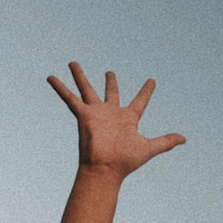

trans_inv: [[ 8.68243129e-01 -4.96138961e-01  3.48469240e+02]
 [ 4.96138961e-01  8.68243129e-01 -5.68183311e+02]]
hand_center: (1244, 372)


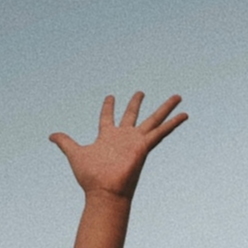

In [29]:
for c_hand in cropped_hands:
    print('trans_inv: {}'.format(c_hand['trans_inv']))
    print('hand_center: {}'.format(c_hand['hand_center']))
    cv2_imshow(c_hand['cropped_img'])

### 関数定義

In [30]:
# 推論後の出力の後処理用関数
# 入力：推論の出力、オリジナル画像の幅高さ
# 出力：オリジナル画像の座標系にリサイズされた手の骨格のkeypoint
def post_process(output, frame_width, frame_height):
    h_scale = frame_height / i_height_hand
    w_scale = frame_width / i_width_hand
    keypoint_coords = np.reshape(np.squeeze(output), (21, 3))
    cv_keypoints = []
    for p in keypoint_coords:
        cv_keypoints.append(cv2.KeyPoint(p[0] * w_scale, p[1] * h_scale, 10.))
    return cv_keypoints

In [31]:
# keypointを正しい位置と角度に戻す関数
# 入力：手のkeypoint、回転行列、手の中心座標、切り抜いた画像の中心座標
# 出力：位置と角度補正後のkeypoint
def reposition(keypoints, trans, center, crp_center):
    rotated_points = []
    dist_x = center[0] - crp_center[0]
    dist_y = center[1] - crp_center[1]
    for k in keypoints:
        p = np.array([[k.pt[0] + dist_x], [k.pt[1] + dist_y], [1]])
        rotated_p = trans.dot(p)
        rotated_points.append(cv2.KeyPoint(int(rotated_p[0]), int(rotated_p[1]), k.size))
    return rotated_points

In [32]:
# 手の骨格を描画する関数
# 入力：描画元画像、keypoint
# 出力：描画後画像
def draw_hand(img, keypoints):
    image = img.copy()
    base = (int(keypoints[0].pt[0]), int(keypoints[0].pt[1]))
    print(base)
    fingers = np.asarray(keypoints[1:]).reshape(5, 4)
    for finger in fingers:
        print((int(finger[0].pt[0]), int(finger[0].pt[1])))
        cv2.line(
            image,
            base,
            (int(finger[0].pt[0]), int(finger[0].pt[1])),
            (0, 0, 255),
            thickness=2
        )
        for i in range(len(finger) - 1):
            cv2.line(
                image,
                (int(finger[i].pt[0]), int(finger[i].pt[1])),
                (int(finger[i+1].pt[0]), int(finger[i+1].pt[1])),
                (0, 0, 255),
                thickness=2
            )
    image = cv2.drawKeypoints(
        image,
        keypoints,
        outImage=np.array([]),
        color=(255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    return image

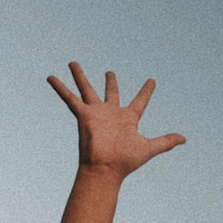

(594, 381)
(606, 358)
(572, 334)
(555, 342)
(544, 353)
(540, 366)


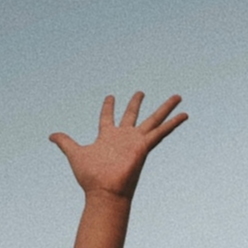

(1201, 421)
(1187, 398)
(1225, 370)
(1242, 377)
(1251, 387)
(1256, 401)


In [33]:
for c_hand in cropped_hands:
    input_image = c_hand['cropped_img'].copy()
    cropped_center = (input_image.shape[1] // 2, input_image.shape[0] // 2)
    # 入力画像を表示します。
    cv2_imshow(input_image)

    # 推論前の前処理をします。
    w, h, _ = input_image.shape
    input_image = cv2.resize(input_image, (i_height_hand, i_width_hand))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255
    input_image = np.expand_dims(input_image, 0).astype(input_details_hand[0]['dtype'])

    # 推論を実行します。
    interpreter_hand.set_tensor(input_details_hand[0]['index'], input_image)
    interpreter_hand.invoke()
    output = interpreter_hand.get_tensor(output_details_hand[2]['index'])

    # 推論後の後処理をします。
    cv_keypoints = post_process(output, w, h)

    # keypointの位置を補正します。
    positioned_keypoints = reposition(
        cv_keypoints,
        c_hand['trans_inv'],
        c_hand['hand_center'],
        cropped_center
    )

    # 骨格を描画します。
    f = draw_hand(f, positioned_keypoints)

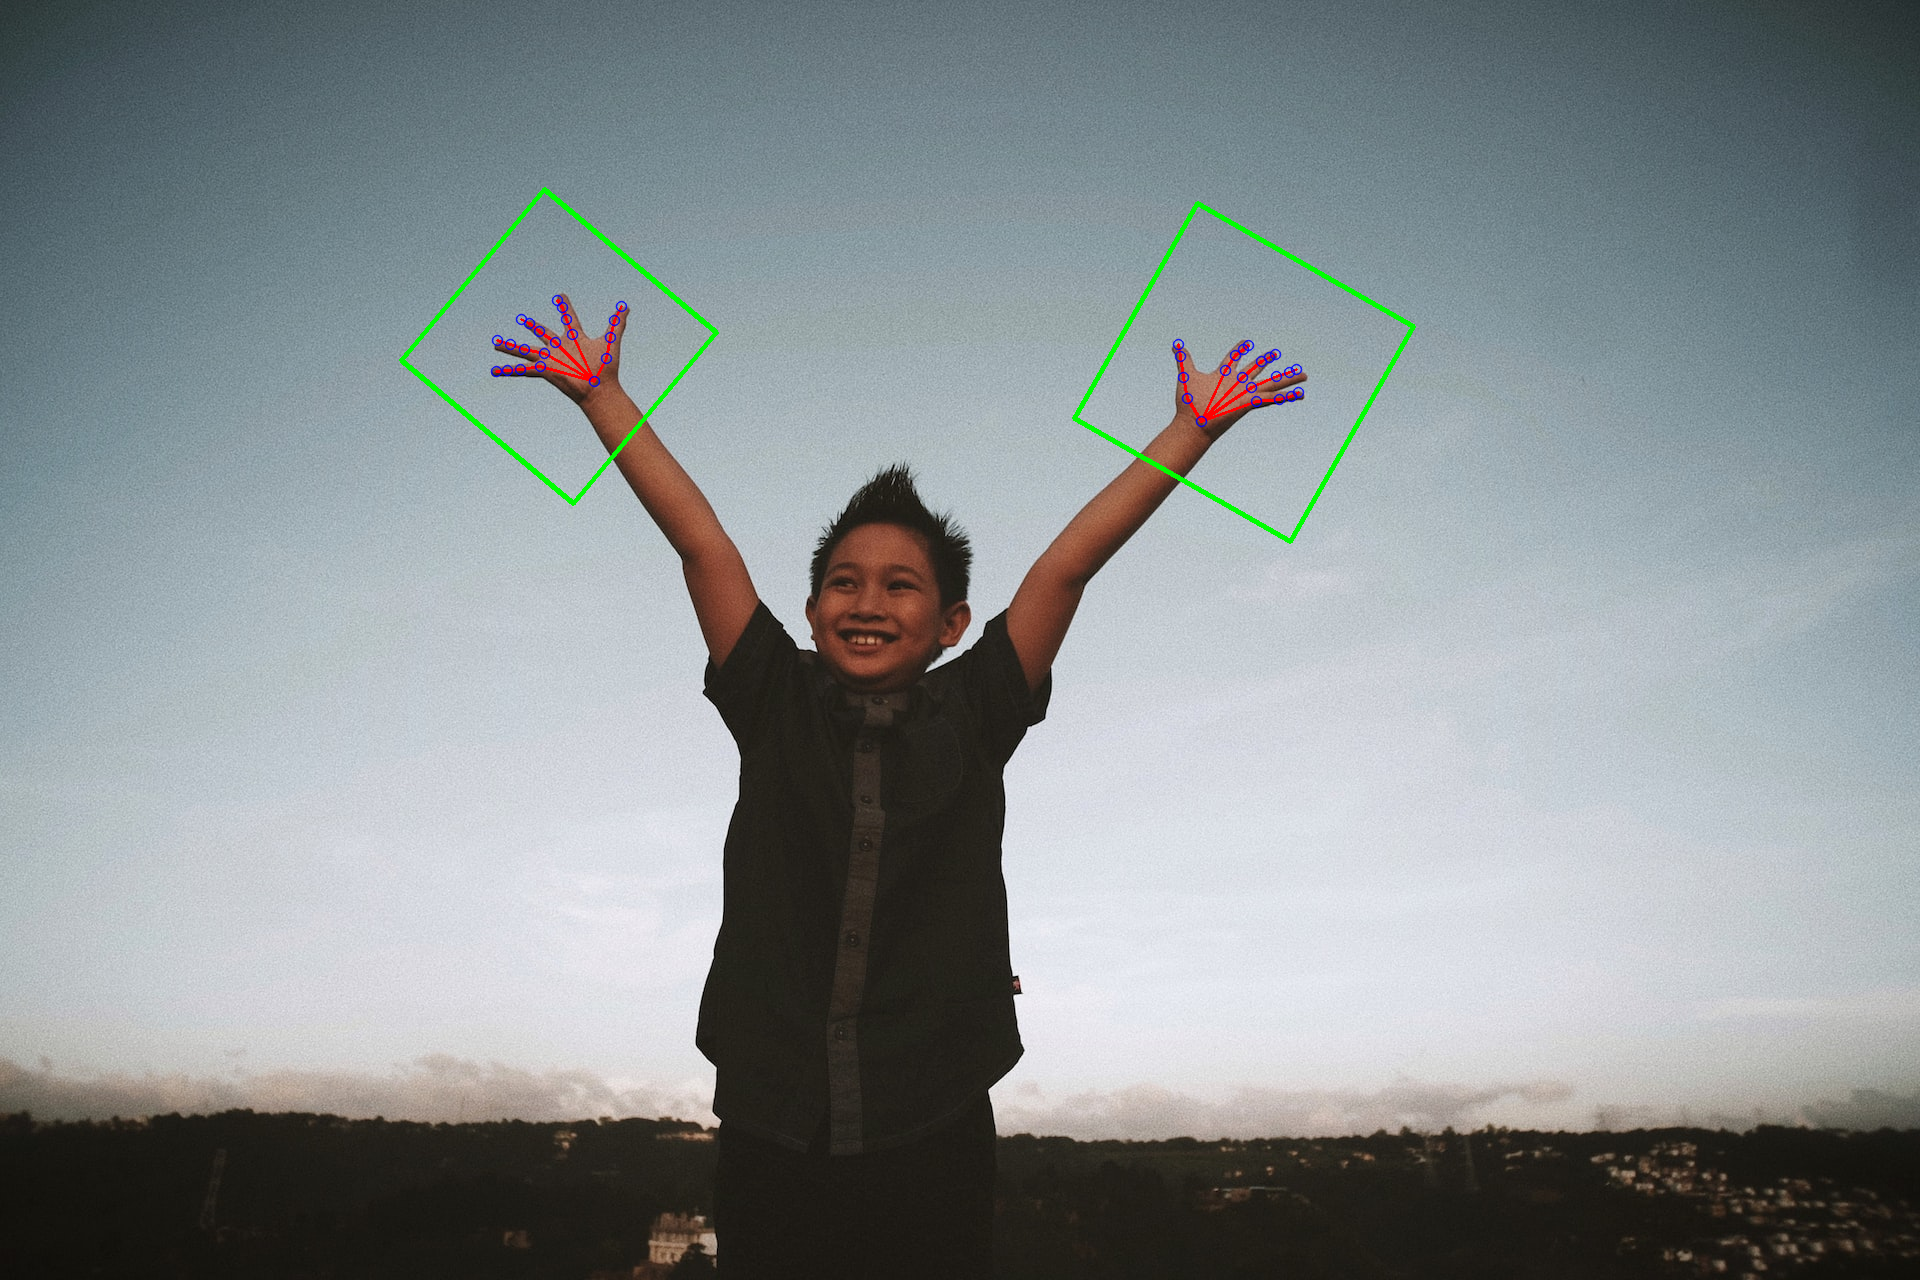

In [34]:
cv2_imshow(f)